# ReSync_for_xdf #

Purpose of the notebook: Show the step-by-step alignment of intracranial and external recordings acquired by Percept DBS electrodes and LSL, respectively. 

1. Recordings are loaded in python
2. The sync artifact is automatically detected in each recording
3. Recordings are both cropped 1 second before the start of this artifact
4. events are transferred from the XDF file (LSL file) to the intracranial recording
5. Each recording is saved separately as a .SET file, containing the electrophysiological traces and events

## 1. Importing necessary tools ##

In [4]:
# Import modules
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from mnelab.io import read_raw
import mne
from copy import deepcopy
from mne.io import read_raw_fieldtrip


# Import custom-made functions
from functions.io import (
    load_mat_file,
    find_EEG_stream,
    load_intracranial_artifact_channel,
    load_xdf_artifact_channel,
    write_set
)
from functions.plotting import (
    xdf_plot_lfp_external
)
from functions.utils import (
    _update_and_save_params, 
    _update_and_save_multiple_params, 
    _get_input_y_n, 
    _get_user_input,
    _get_onedrive_path
)
from functions.find_artifacts import (
    detect_artifacts_in_external_recording,
    detect_artifacts_in_intracranial_recording
)
from functions.timeshift import check_timeshift

%matplotlib inline

## 2. Choose the session to synchronize ##

In [7]:
## FILL OUT THESE PARAMETERS FOR EACH NEW SESSION 
session_ID="sub007 MID DBS OFF"
fname_lfp="sub-007_ses-Fu24mMedOn01_task-MID_acq-StimOff_mod-BrainSenseBip_run-1.mat"
fname_external="sub-007_ses-MID_OFF_task-Default_run-001_eeg.xdf"
ch_idx_lfp=0
BIP_ch_name="BIP 01"
DBS_status = 'DBS OFF'

## 3. Setting the paths ##

In [8]:
"""
### Method 1: use the folders from the repository itself. Upgraded to method 2: extract the data directly from a structured Teams folder.
working_path = os.getcwd()
repo_path = os.path.dirname(working_path)

#  Set saving path
results_path = join(repo_path, "results")

#  Set source path
source_path = join(repo_path, "sourcedata")

# automatic saving of datas and figures
saving_path = join(results_path, session_ID)
if not os.path.isdir(saving_path):
    os.makedirs(saving_path)
"""

### Method 2: extract the data from Teams
onedrivepath = _get_onedrive_path()

# Set sourcepath and saving path:
subject_path = join(onedrivepath, session_ID[:6])
raw_data_path = join(subject_path, "raw_data")
pre_lfp_source_path = join(raw_data_path, "JSON")
lfp_source_path = join(pre_lfp_source_path, DBS_status)
pre_external_source_path = join(raw_data_path, "XDF")
external_source_path = join(pre_external_source_path, DBS_status)

results_path = join(subject_path, "synced_data")
if not os.path.isdir(results_path):
    os.makedirs(results_path)
saving_path = join(results_path, session_ID)
if not os.path.isdir(saving_path):
    os.makedirs(saving_path)


## 4. Loading the datasets and extract the channel containing the artifacts ##

In [9]:
data = read_raw_fieldtrip(join(lfp_source_path, fname_lfp), info={}, data_name="data")

c:\Users\Juliette\anaconda3\envs\resync_xdf\Lib\site-packages\pymatreader\utils.py:238: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Creating RawArray with float64 data, n_channels=6, n_times=268500
    Range : 0 ... 268499 =      0.000 ...  1073.996 secs
Ready.


C:\Users\Juliette\AppData\Local\Temp\ipykernel_15464\3543324328.py:1: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(join(lfp_source_path, fname_lfp), info={}, data_name="data")
C:\Users\Juliette\AppData\Local\Temp\ipykernel_15464\3543324328.py:1: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_02. Making it a MISC channel.
  data = read_raw_fieldtrip(join(lfp_source_path, fname_lfp), info={}, data_name="data")
C:\Users\Juliette\AppData\Local\Temp\ipykernel_15464\3543324328.py:1: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_02. Making it a MISC channel.
  data = read_raw_fieldtrip(join(lfp_source_path, fname_lfp), info={}, data_name="data")
C:\Users\Juliette\AppData\Local\Temp\ipykernel_15464\3543324328.py:1: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_02_PEAK29Hz_THR20-30_AVG3

In [11]:
#  1. LOADING DATASETS AND EXTRACT CHANNEL CONTAINING ARTIFACTS:
    ##  Intracranial LFP
lfp_rec = load_mat_file(
        session_ID=session_ID,
    filename=fname_lfp,
    saving_path=saving_path,
    source_path=lfp_source_path,
)
sf_LFP = lfp_rec.info["sfreq"] # sampling frequency of intracranial recording
dictionary = {"SF_INTERNAL": sf_LFP, "CH_IDX_LFP": ch_idx_lfp}
_update_and_save_multiple_params(dictionary, session_ID, saving_path)
lfp_sig = load_intracranial_artifact_channel(lfp_rec, 0)

Creating RawArray with float64 data, n_channels=6, n_times=268500
    Range : 0 ... 268499 =      0.000 ...  1073.996 secs
Ready.


c:\Users\Juliette\Research\Projects\ReSync_for_xdf\scripts\functions\io.py:42: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\Juliette\Research\Projects\ReSync_for_xdf\scripts\functions\io.py:42: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_02. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\Juliette\Research\Projects\ReSync_for_xdf\scripts\functions\io.py:42: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_02. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\Juliette\Research\Projects\ReSync_for_xdf\scripts\functions\io.py:42: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_02_PEAK29Hz_THR20-30_AVG3000ms. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\Juliette\Research\Projects\ReSync_for_xdf\scripts\functions\io.py:42: Run

In [12]:
##  External data from XDF
# load external dataset into mne
_update_and_save_params("FNAME_EXTERNAL", fname_external, session_ID, saving_path)
fpath_external = join(external_source_path, fname_external)  
stream_id = find_EEG_stream(fpath_external, stream_name = 'SAGA')  # find the stream_id of the EEG data, which is called 'SAGA' in our setup
TMSi_rec = read_raw(fpath_external, stream_ids = [stream_id], preload=True)
sf_external = (TMSi_rec.info["sfreq"]) # sampling frequency of external recording
sf_external = round(sf_external)  # handle cases when the sf_external is not an integer (as it should be by definition during the recording itself)
BIP_channel, ch_index_external = load_xdf_artifact_channel(TMSi_rec, BIP_ch_name, session_ID,saving_path)
dictionary = {"SF_EXTERNAL": sf_external, "CH_IDX_EXTERNAL": ch_index_external}
_update_and_save_multiple_params(dictionary, session_ID, saving_path)


Creating RawArray with float64 data, n_channels=42, n_times=2194407
    Range : 0 ... 2194406 =      0.000 ...  1071.496 secs
Ready.


## 5. Find the stimulation artifact ##

### 5.1. In the external recording ###

external signal is reversed
invertion undone
7.8134765625


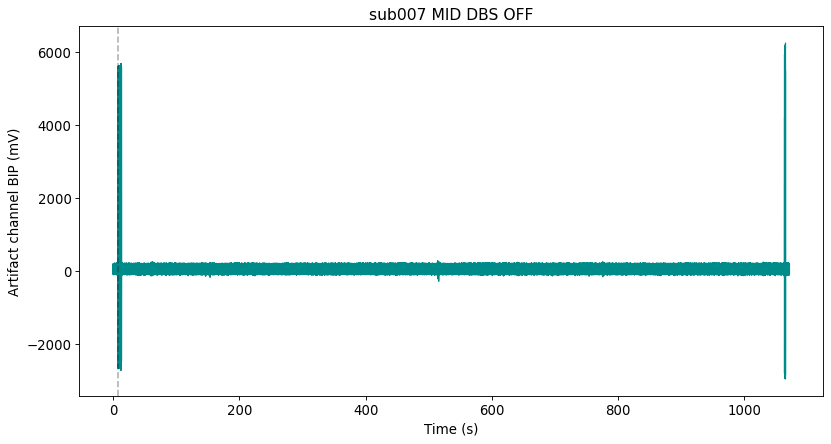

Start index: 15942, End index: 16062


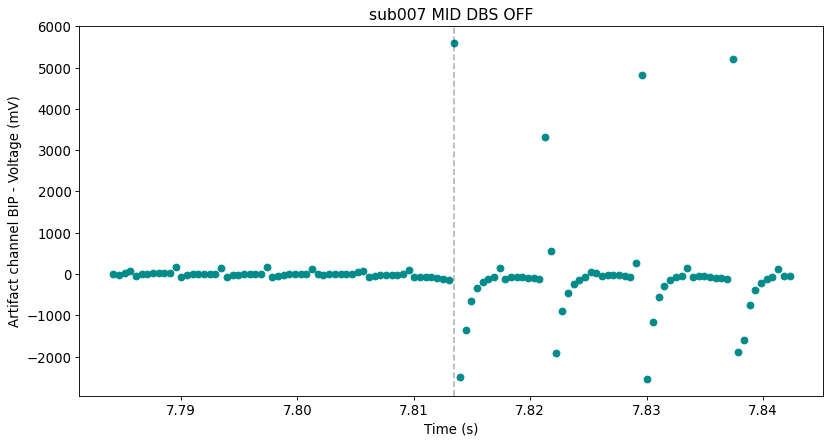

In [13]:
art_start_BIP = detect_artifacts_in_external_recording(
    session_ID=session_ID,
    BIP_channel=BIP_channel,
    sf_external=sf_external,
    saving_path=saving_path,
    start_index=0,
)
artifact_correct = _get_input_y_n(
    "Is the external DBS artifact properly selected ? "
)

if artifact_correct in ("y", "Y"):
    _update_and_save_params(
        key="ART_TIME_BIP",
        value=art_start_BIP,
        session_ID=session_ID,
        saving_path=saving_path
    )
else:
    # if there's an unrelated artifact or if the stimulation is ON at the beginning
    # of the recording, the user can input the number of seconds to ignore at the
    # beginning of the recording, and the function will start looking for artifacts
    # after that time.
    start_later = _get_user_input(
        "How many seconds in the beginning should be ignored "
    )
    start_later_index = start_later * sf_external
    art_start_BIP = detect_artifacts_in_external_recording(
        session_ID=session_ID,
        BIP_channel=BIP_channel,
        sf_external=sf_external,
        saving_path=saving_path,
        start_index=start_later_index,
    )
    _update_and_save_params(
        key="ART_TIME_BIP",
        value=art_start_BIP,
        session_ID=session_ID,
        saving_path=saving_path,
    )

### 5.2. In the intracranial recording ###

Running resync with method = thresh...


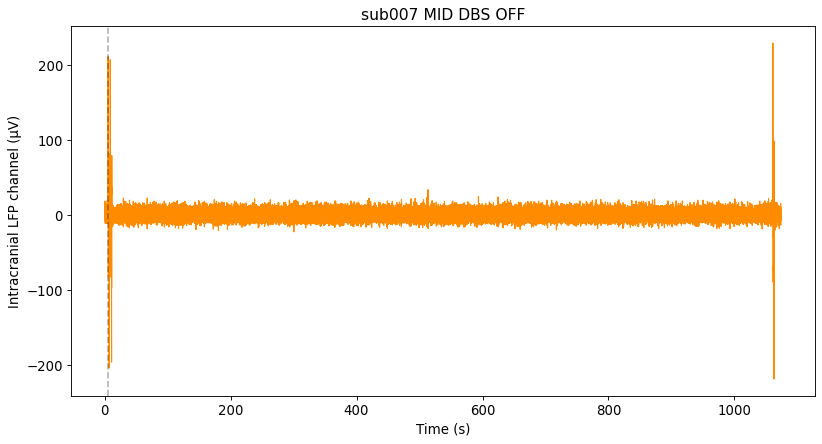

idx_start: 1339
idx_end: 1409
Start index: 1339, End index: 1409


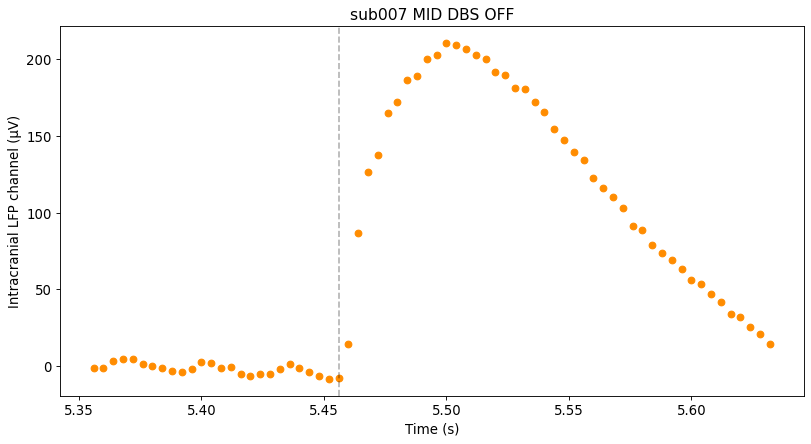

In [14]:
# 2.2. Find artifacts in intracranial recording:
methods = ["thresh", "2", "1", "manual"]
# thresh takes the last sample that lies within the value distribution of the 
    # thres_window (aka: baseline window) before the threshold passing
# kernel 1 only searches for the steep decrease
# kernel 2 is more custom and takes into account the steep decrease and slow recover
# manual kernel is for none of the three previous methods work. Then the artifact
    # has to be manually selected by the user, in a pop up window that will automatically open.
for method in methods:
    print("Running resync with method = {}...".format(method))
    art_start_LFP = detect_artifacts_in_intracranial_recording(
        session_ID=session_ID,
        lfp_sig=lfp_sig,
        sf_LFP=sf_LFP,
        saving_path=saving_path,
        method=method
    )

    artifact_correct = _get_input_y_n(
        "Is the intracranial DBS artifact properly selected ? "
    )
    if artifact_correct in ("y","Y"):
        dictionary = {"ART_TIME_LFP": art_start_LFP, "METHOD": method}
        _update_and_save_multiple_params(dictionary,session_ID,saving_path)
        break

## 6. Synchronize recordings and transfer behavioural task events ##

In [15]:
## detect events in external dataset
events, _ = mne.events_from_annotations(TMSi_rec)
inv_dic = {v: k for k, v in _.items()}

## offset intracranial recording (crop everything that is more than 1s before the artifact)
tmax_lfp = max(lfp_rec.times)
new_start_intracranial = art_start_LFP - 1
lfp_rec_offset = lfp_rec.copy().crop(tmin=new_start_intracranial, tmax=tmax_lfp)
#lfp_rec_offset.plot(title="lfp_rec_offset")

## offset external recording (crop everything that is more than 1s before the artifact)
tmax_external = max(TMSi_rec.times)
new_start_external = art_start_BIP - 1
TMSi_rec_offset = TMSi_rec.copy().crop(tmin=new_start_external, tmax=tmax_external)
#TMSi_rec_offset.plot(title='TMSi_rec_offset')

## transfer of the events from the external to the intracranial recording
# create a duplicate of the events to manipulate it without changing the external one
events_lfp = deepcopy(events)

# get the events from the external in time instead of samples to account for the different sampling frequencies
events_in_time = events[:,0]/sf_external

# then offset the events in time to the new start of the external recording
events_in_time_offset = events_in_time - new_start_external

# convert the events in time offset to samples corresponding to the sampling frequency of the intracranial recording
# because the annotations object works with samples, not timings
events_in_time_offset_lfp = events_in_time_offset * sf_LFP
events_lfp[:,0] = events_in_time_offset_lfp

## create an annotation object for the intracranial recording
annotations_lfp = mne.annotations_from_events(events_lfp, sfreq=sf_LFP, event_desc=inv_dic)

lfp_rec_offset.set_annotations(None) # make sure that no annotations are present
lfp_rec_offset.set_annotations(annotations_lfp) # set the new annotations


Used Annotations descriptions: ['Correct', 'Feedback', 'Fixation', 'ITI', 'Late', 'Loss_cue', 'Neutral_cue', 'Target', 'Win_cue']


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,0 points
Good channels,"4 misc, 2 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


## 7. Save both recordings separately (creates 2 .SET files) ##

In [16]:
external_title = ("SYNCHRONIZED_EXTERNAL_" + str(fname_external[:-4]) + ".set")
fname_external_out=join(saving_path, external_title)
TMSi_rec_offset_annotations_onset= (TMSi_rec_offset.annotations.onset) - new_start_external
lfp_title = ("SYNCHRONIZED_INTRACRANIAL_" + str(fname_lfp[:-4]) + ".set")
fname_lfp_out =join(saving_path, lfp_title)
lfp_rec_offset_annotations_onset= (lfp_rec_offset.annotations.onset) - new_start_intracranial

write_set(fname_external_out, TMSi_rec_offset, TMSi_rec_offset_annotations_onset)
write_set(fname_lfp_out, lfp_rec_offset, lfp_rec_offset_annotations_onset)

## 8. Optional: plot the two artifact channels after synchronization to verify that the stimulation pulses are well aligned at the beginning and at the end. ##

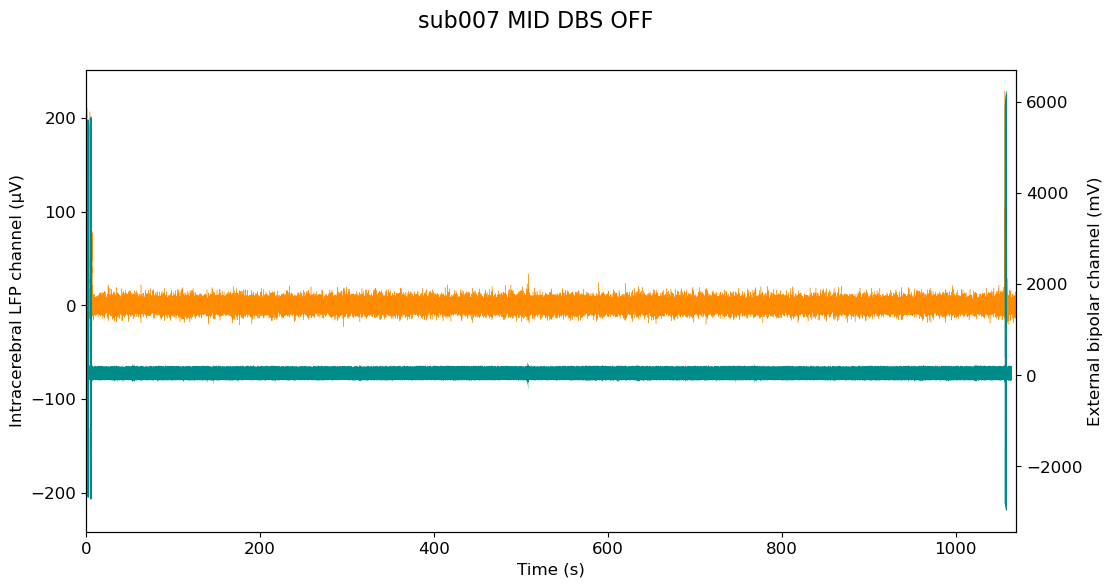

In [17]:
%matplotlib inline

xdf_plot_lfp_external(TMSi_rec_offset, lfp_rec_offset, ch_index_external, ch_idx_lfp, sf_LFP, sf_external, saving_path, session_ID)

## 9. OPTIONAL : check the timeshift with the last artifact at the end of both recordings ##

## DOES NOT WORK IN NOTEBOOK ##

In [19]:
external_synchronized = TMSi_rec_offset.get_data()
LFP_synchronized = lfp_rec_offset.get_data()

In [18]:
%matplotlib qt

In [20]:
### DOES NOT WORK IN NOTEBOOK ###

check_timeshift(
            session_ID=session_ID,
            LFP_synchronized=LFP_synchronized,
            sf_LFP=sf_LFP,
            external_synchronized=external_synchronized,
            sf_external=sf_external,
            saving_path=saving_path,
        )

(267386,)
<class 'numpy.ndarray'>
(2180453,)
<class 'numpy.ndarray'>
Select the first sample of the last artifact in the intracranial recording
Input must be `y` or `n`. Got: . Please provide a valid input.


IndexError: list index out of range